## Feature Engineering
In this section, we apply various feature engineering techniques to our dataset. Feature engineering is a critical step in the pre-processing phase where we prepare the variables for modeling. This includes handling missing values, discarding or re-encoding rare labels, transforming the distribution of variables, and deriving new features based on domain knowledge.

### Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.ticker as ticker

# Settings for better readability
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 75

# To supress scientific notations for a dataframe
pd.set_option("display.float_format", lambda x: "%.2f" % x)

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Defining Functions

**The below functions need to be defined to carry out the EDA.**

In [2]:
# function to plot a boxplot and a histogram along the same scale.

def histogram_boxplot(data, feature, figsize=(10, 5), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a triangle will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

In [3]:
# function to create labeled barplots

def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 2, 6))
    else:
        plt.figure(figsize=(n + 2, 6))

    plt.xticks(rotation=90, fontsize=15)
    palette = sns.color_palette("deep")[0]  # This gives the first color of the 'deep' palette which is a blue
    ax = sns.countplot(
        data=data,
        x=feature,
        color=palette,
        palette="Paired",
        order=data[feature].value_counts().index[:n],
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

### Load Dataset

In [4]:
data = pd.read_csv("../data/eda_dataset.csv")

In [5]:
# Create a copy of the dataset to preserve the original
df = data.copy()

## Data Cleaning and Preparation
Before diving into the analysis, let's clean and prepare our data. This includes handling missing values, converting data types if necessary, and creating new columns for our analysis.

**Missing values**

In [6]:
# Fill missing values in 'title' with a placeholder
df['title'].fillna('Unknown', inplace=True)

### Calculating discount percent

In [7]:
# Adjusting list_price to be equal to price where there were no discounts (list_price = 0)
df['list_price'] = df.apply(lambda row: row['price'] if row['list_price'] < row['price'] else row['list_price'], axis=1)

In [8]:
# Create a new column for the discount amount
df['discount'] = df['list_price'] - df['price']

In [9]:
# Create a percentage discount column
df['discount_percent'] = (df['discount'] / df['list_price']) * 100

In [10]:
# Replace infinite values and NaN values in discount_percent with zero
df['discount_percent'].replace([np.inf, -np.inf], 0, inplace=True)
df['discount_percent'].fillna(0, inplace=True)

**Create flag for whether product was discounted**

In [11]:
# Discount indicated where price < list_price
df['is_discounted'] = (df['price'] < df['list_price']).astype(int)

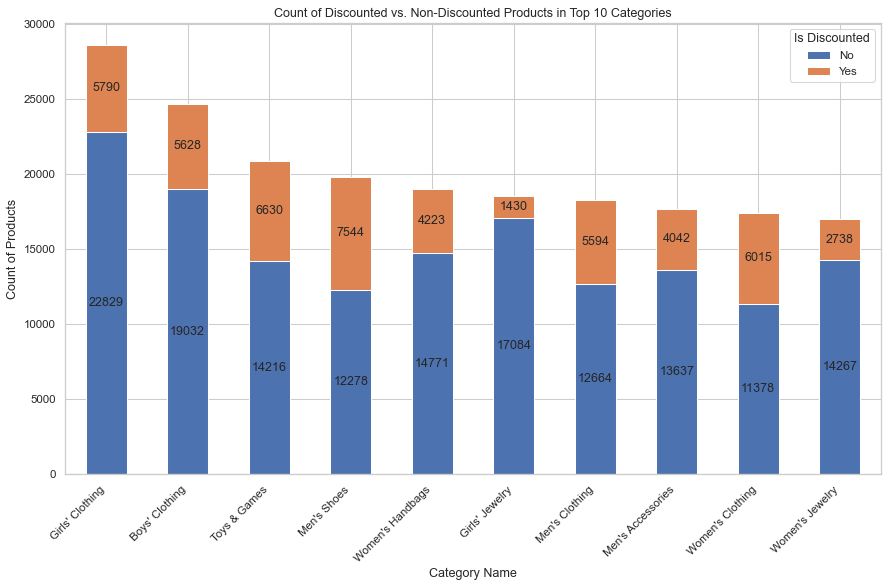

In [12]:
# Group the data by 'category_name' and 'is_discounted', then count the products
category_discount_counts = df.groupby(['category_name', 'is_discounted']).size().unstack(fill_value=0)

# Calculate the total number of products per category
category_discount_counts['total'] = category_discount_counts.sum(axis=1)

# Sort categories by the total number of products and select the top 10
top_10_categories = category_discount_counts.sort_values(by='total', ascending=False).head(10)

# Drop the total column as it's no longer needed
top_10_categories = top_10_categories.drop(columns='total')

# Create a stacked bar chart for the top 10 categories
ax = top_10_categories.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Count of Discounted vs. Non-Discounted Products in Top 10 Categories')
plt.xlabel('Category Name')
plt.ylabel('Count of Products')
plt.xticks(rotation=45, ha='right')  # Rotate the category names for better readability
plt.legend(title='Is Discounted', labels=['No', 'Yes'])  # Adjust legend labels for clarity

# Add labels on the bars
for bars in ax.containers:
    ax.bar_label(bars, label_type='center')

plt.tight_layout()  # Adjust the lay

**We can drop 'list_price' now that we've calculated discount**

In [13]:
df.drop(columns='list_price', axis=1, inplace=True)

### Creating sales revenue feature as 'sales'

In [14]:
df['sales'] = df['price'] * df['units']

**Let's see which categories are biggest sellers**

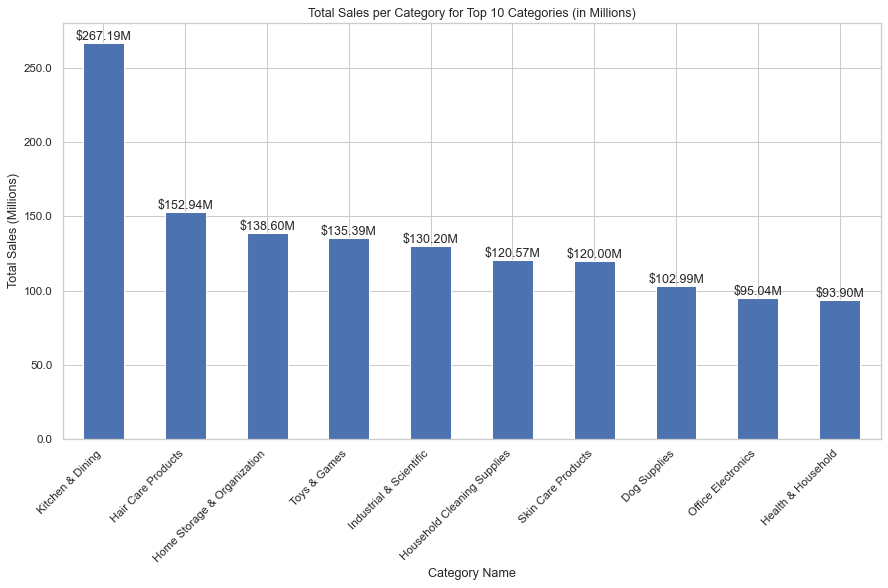

In [15]:
# Group by 'category_name' and calculate the sum of 'sales' for each category
category_sales = df.groupby('category_name')['sales'].sum().sort_values(ascending=False)

# Select only the top 10 categories
top_10_category_sales = category_sales.head(10)

# Create a bar chart of the total sales for the top 10 categories
plt.figure(figsize=(12, 8))  # Adjust the figure size as needed
bars = top_10_category_sales.plot(kind='bar')
plt.title('Total Sales per Category for Top 10 Categories (in Millions)')
plt.xlabel('Category Name')
plt.ylabel('Total Sales (Millions)')

# Format the y-axis labels to show as millions
bars.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(x / 1_000_000, ',')))

# Rotate the category names for better readability
plt.xticks(rotation=45, ha='right')

# Add labels on the bars
for bar in bars.patches:
    # Format the label to show in millions and round to 2 decimal places
    label = "${:.2f}M".format(bar.get_height() / 1_000_000)
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height(),
             label,
             ha='center',
             va='bottom')

plt.tight_layout()  # Adjust the layout to fit everything nicely
plt.show()

**Let's see what percent of sales and units are coming from discounts**

In [16]:
# What percent of sales are coming from discounts?
print("Discounted sales as a % of total sales: ", (df.discount.sum()/df.sales.sum()).round(4) * 100, "%", sep='')

# What percent of units are coming from discounts?
print("Discounted units as a % of total sales: ", (df.discount.sum()/df.units.sum()).round(2) * 100, "%", sep='')

Discounted sales as a % of total sales: 0.09%
Discounted units as a % of total sales: 2.0%


**What are most discounted categories?**

In [17]:
category_discounts = df.groupby('category_name').agg(
    total_products=('is_discounted', 'count'),  # Count total products in each category
    discounted_products=('is_discounted', 'sum')  # Sum up the discounted products (1s in the is_discounted column)
)

# Calculate the percentage of discounted products for each category
category_discounts['percent_discounted'] = (category_discounts['discounted_products'] / category_discounts['total_products']) * 100

# Display the result
category_discounts[['percent_discounted']].sort_values(by='percent_discounted', ascending=False).head(10)

,percent_discounted
category_name,
Health & Household,57.73
Tools & Home Improvement,53.69
Smart Home: Security Cameras and Systems,48.55
Sports & Outdoors,47.81
Personal Care Products,44.27
Smart Home - Heating & Cooling,43.73
Computers,43.58
Smart Home: Other Solutions,43.57
Sports & Fitness,42.89


- Majority of top 10 discounted categories are electronics/games

**Which categories are not discounted?**

In [18]:
category_discounts[category_discounts['percent_discounted'] == 0].sort_values(by='total_products', ascending=False)

,total_products,discounted_products,percent_discounted
category_name,,,
Gift Cards,139,0,0.00


**Creating title length feature**

In [19]:
df['title_length'] = df['title'].apply(len)

C:\Users\chris\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\chris\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\chris\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


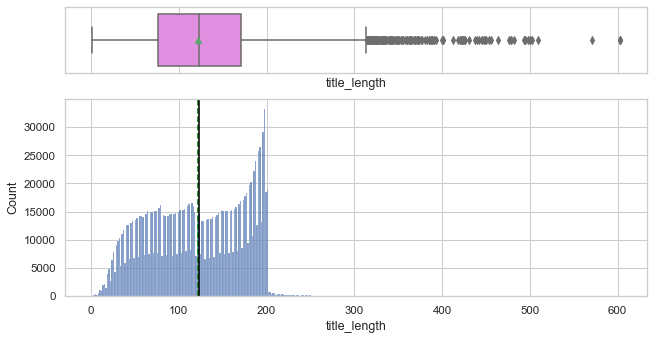

In [20]:
# Let's visualize it
histogram_boxplot(df, 'title_length')

- 50% of titles have lenght between about 80 and 175
- The most common length (mode) is just under 200

**Creating star rating flag (greater than or equal to median 4.4)**

In [21]:
# Define the high rating threshold
high_rating_threshold = 4.4

# Create the 'High-Rating Flag' column
df['high_rating_flag'] = (df['stars'] >= high_rating_threshold).astype(int)

C:\Users\chris\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\chris\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


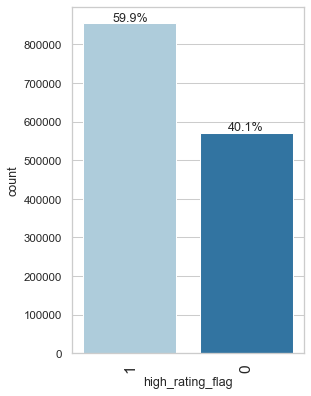

In [22]:
# Let's visualize it
labeled_barplot(df, 'high_rating_flag', perc=True)

- About 60% of products have a high rating (>= 4.4)

**Bar Chart of 'High-Rating Flag' Count per Category**

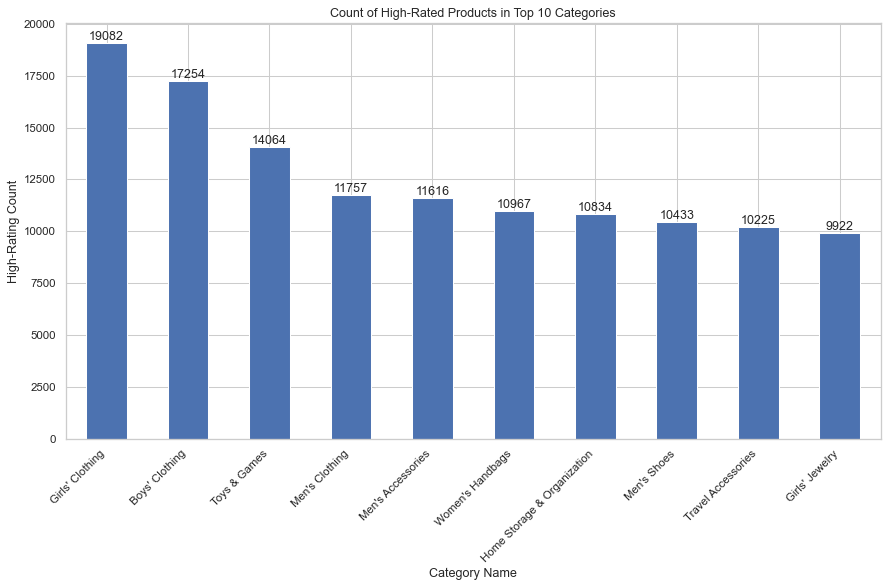

In [23]:
# Filter the DataFrame to only include high-rated products
high_rated_products = df[df['high_rating_flag'] == 1]

# Group by 'category_name' and count the number of high-rated products in each category
high_rating_count_per_category = high_rated_products.groupby('category_name').size().sort_values(ascending=False)

# Select only the top 10 categories
top_10_high_rating_count = high_rating_count_per_category.head(10)

# Create a bar chart for the count of high-rated products in the top 10 categories
plt.figure(figsize=(12, 8))  # Adjust the figure size as needed
bars = top_10_high_rating_count.plot(kind='bar')
plt.title('Count of High-Rated Products in Top 10 Categories')
plt.xlabel('Category Name')
plt.ylabel('High-Rating Count')
plt.xticks(rotation=45, ha='right')  # Rotate the category names for better readability

# Add labels on the bars
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height(),
             round(bar.get_height(), 2),
             ha='center',
             va='bottom')

plt.tight_layout()  # Adjust the layout to fit everything nicely
plt.show()

- 8 of top 10 highly rated categories are apparel and accessories

**Creating price range feature (may help analyze sales patterns across different price levels**

In [24]:
# Define price range thresholds based on the quartiles
low_price_threshold = 11.99
medium_price_threshold = 36.99

# Define a function to categorize each price
def categorize_price(price):
    if price <= low_price_threshold:
        return 'Low'
    elif price <= medium_price_threshold:
        return 'Medium'
    else:
        return 'High'

# Apply the function to the 'price' column to create the 'Price Range' column
df['price_range'] = df['price'].apply(categorize_price)

C:\Users\chris\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\chris\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


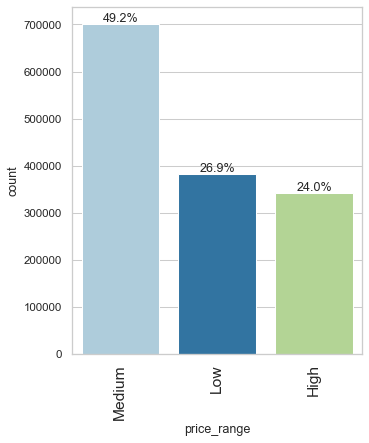

In [25]:
# Let's visualize it
labeled_barplot(df, 'price_range', perc=True)

**Creating review score feature (may give a more robust indication of customer satisfaction**

In [26]:
# Define a function to calculate the weighted review score
def calculate_review_score(stars, reviews):
    # You might want to adjust the formula as needed
    return stars * np.log1p(reviews)  # log1p is log(1 + reviews) to handle cases where reviews are 0; it is used to ensure that the score doesn't overly favor products with an extremely high number of reviews.

# Apply the function to the 'stars' and 'reviews' columns to create the 'Review Score' column
df['review_score'] = df.apply(lambda row: calculate_review_score(row['stars'], row['reviews']), axis=1)

In [27]:
# Checking number of records where review_score is zero
(df.review_score==0).sum()/df.shape[0]

0.7925917928231547

- 79% of review_score are zero, so we can filter a scatterplot to see if it reveals a better pattern where the review score is present and might be meaningful

C:\Users\chris\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\chris\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='review_score', ylabel='stars'>

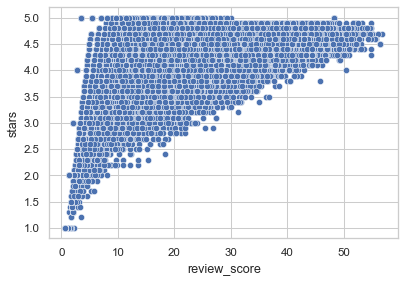

In [28]:
non_zero_reviews = df[df['review_score'] > 0]
sns.scatterplot(non_zero_reviews, x='review_score', y='stars')

**Context Matters**: Remember that a lack of a strong relationship in the data is also a form of insight. If 'review_score' and 'stars' aren't strongly correlated, that might suggest that the way you're calculating 'review_score' doesn't align well with how users rate products, or it might highlight the influence of other factors on user ratings.

**Peeking at the revised dataframe**

In [29]:
df.head()

,title,img_url,product_url,stars,reviews,price,is_best_seller,units,category_name,discount,discount_percent,is_discounted,sales,title_length,high_rating_flag,price_range,review_score
0,"Sion Softside Expandable Roller Luggage, Black...",https://m.media-amazon.com/images/I/815dLQKYIY...,https://www.amazon.com/dp/B014TMV5YE,4.50,0,139.99,False,2000,Suitcases,0.00,0.00,0,279980.00,69,1,High,0.00
1,Luggage Sets Expandable PC+ABS Durable Suitcas...,https://m.media-amazon.com/images/I/81bQlm7vf6...,https://www.amazon.com/dp/B07GDLCQXV,4.50,0,169.99,False,1000,Suitcases,40.00,19.05,1,169990.00,75,1,High,0.00
2,Platinum Elite Softside Expandable Checked Lug...,https://m.media-amazon.com/images/I/71EA35zvJB...,https://www.amazon.com/dp/B07XSCCZYG,4.60,0,365.49,False,300,Suitcases,64.50,15.00,1,109647.00,141,1,High,0.00
3,Freeform Hardside Expandable with Double Spinn...,https://m.media-amazon.com/images/I/91k6NYLQyI...,https://www.amazon.com/dp/B08MVFKGJM,4.60,0,291.59,False,400,Suitcases,62.78,17.72,1,116636.00,82,1,High,0.00
4,Winfield 2 Hardside Expandable Luggage with Sp...,https://m.media-amazon.com/images/I/61NJoaZcP9...,https://www.amazon.com/dp/B01DJLKZBA,4.50,0,174.99,False,400,Suitcases,135.00,43.55,1,69996.00,92,1,High,0.00


**Checking statistical summary**

In [30]:
df.describe()

,stars,reviews,price,units,discount,discount_percent,is_discounted,sales,title_length,high_rating_flag,review_score
count,1426337.00,1426337.00,1426337.00,1426337.00,1426337.00,1426337.00,1426337.00,1426337.00,1426337.00,1426337.00,1426337.00
mean,4.00,180.75,43.38,141.98,2.81,5.08,0.24,3260.64,121.39,0.60,4.24
std,1.34,1761.45,130.29,836.27,13.45,11.24,0.43,23338.66,53.87,0.49,9.44
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
25%,4.10,0.00,11.99,0.00,0.00,0.00,0.00,0.00,76.00,0.00,0.00
50%,4.40,0.00,19.95,0.00,0.00,0.00,0.00,0.00,123.00,1.00,0.00
75%,4.60,0.00,35.99,50.00,0.00,0.00,0.00,1249.50,171.00,1.00,0.00
max,5.00,346563.00,19731.81,100000.00,797.01,100.00,1.00,4999900.00,603.00,1.00,56.81


In [31]:
df.describe(include="all")

,title,img_url,product_url,stars,reviews,price,is_best_seller,units,category_name,discount,discount_percent,is_discounted,sales,title_length,high_rating_flag,price_range,review_score
count,1426337,1426337,1426337,1426337.00,1426337.00,1426337.00,1426337,1426337.00,1426337,1426337.00,1426337.00,1426337.00,1426337.00,1426337.00,1426337.00,1426337,1426337.00
unique,1385431,1372162,1426337,NaN,NaN,NaN,2,NaN,248,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN
top,Men's Sneaker,https://m.media-amazon.com/images/I/01RmK+J4pJ...,https://www.amazon.com/dp/B014TMV5YE,NaN,NaN,NaN,False,NaN,Girls' Clothing,NaN,NaN,NaN,NaN,NaN,NaN,Medium,NaN
freq,89,1130,1,NaN,NaN,NaN,1417817,NaN,28619,NaN,NaN,NaN,NaN,NaN,NaN,701420,NaN
mean,NaN,NaN,NaN,4.00,180.75,43.38,NaN,141.98,NaN,2.81,5.08,0.24,3260.64,121.39,0.60,NaN,4.24
std,NaN,NaN,NaN,1.34,1761.45,130.29,NaN,836.27,NaN,13.45,11.24,0.43,23338.66,53.87,0.49,NaN,9.44
min,NaN,NaN,NaN,0.00,0.00,0.00,NaN,0.00,NaN,0.00,0.00,0.00,0.00,1.00,0.00,NaN,0.00
25%,NaN,NaN,NaN,4.10,0.00,11.99,NaN,0.00,NaN,0.00,0.00,0.00,0.00,76.00,0.00,NaN,0.00
50%,NaN,NaN,NaN,4.40,0.00,19.95,NaN,0.00,NaN,0.00,0.00,0.00,0.00,123.00,1.00,NaN,0.00
75%,NaN,NaN,NaN,4.60,0.00,35.99,NaN,50.00,NaN,0.00,0.00,0.00,1249.50,171.00,1.00,NaN,0.00


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1426337 entries, 0 to 1426336
Data columns (total 17 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   title             1426337 non-null  object 
 1   img_url           1426337 non-null  object 
 2   product_url       1426337 non-null  object 
 3   stars             1426337 non-null  float64
 4   reviews           1426337 non-null  int64  
 5   price             1426337 non-null  float64
 6   is_best_seller    1426337 non-null  bool   
 7   units             1426337 non-null  int64  
 8   category_name     1426337 non-null  object 
 9   discount          1426337 non-null  float64
 10  discount_percent  1426337 non-null  float64
 11  is_discounted     1426337 non-null  int32  
 12  sales             1426337 non-null  float64
 13  title_length      1426337 non-null  int64  
 14  high_rating_flag  1426337 non-null  int32  
 15  price_range       1426337 non-null  object 
 16  

In [33]:
df.describe(exclude=np.number).T

,count,unique,top,freq
title,1426337,1385431,Men's Sneaker,89
img_url,1426337,1372162,https://m.media-amazon.com/images/I/01RmK+J4pJ...,1130
product_url,1426337,1426337,https://www.amazon.com/dp/B014TMV5YE,1
is_best_seller,1426337,2,False,1417817
category_name,1426337,248,Girls' Clothing,28619
price_range,1426337,3,Medium,701420


#### Let's perform some additional exploratory data analysis to understand the distribution of discounts and how they relate to other features like stars, isBestSeller, etc.

C:\Users\chris\AppData\Local\Temp\ipykernel_26404\431617622.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(discount_percent_filtered.dropna())
C:\Users\chris\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\chris\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.u

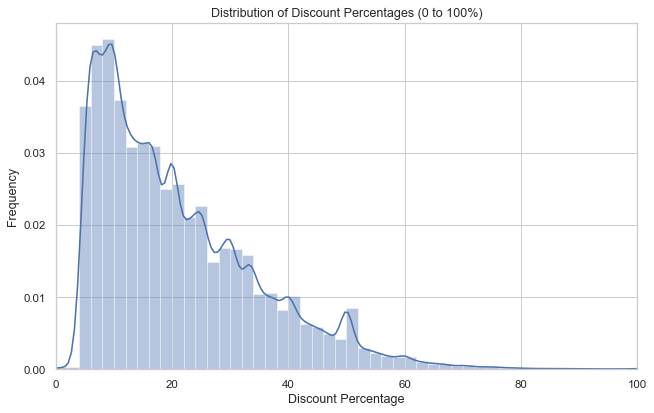

In [34]:
# Filter out zero values and values over 100%
discount_percent_filtered = df['discount_percent'][(df['discount_percent'] > 0) & (df['discount_percent'] <= 100)]

# Distribution of non-zero and <=100% discount percentages
plt.figure(figsize=(10,6))
sns.distplot(discount_percent_filtered.dropna())
plt.title('Distribution of Discount Percentages (0 to 100%)')
plt.xlabel('Discount Percentage')
plt.ylabel('Frequency')
plt.xlim(0, 100)  # Set x-axis limit from 0 to 100
plt.show()

- The distribution is right-skewed. The majority of discounts are under 20%, with most frequent near 10%.

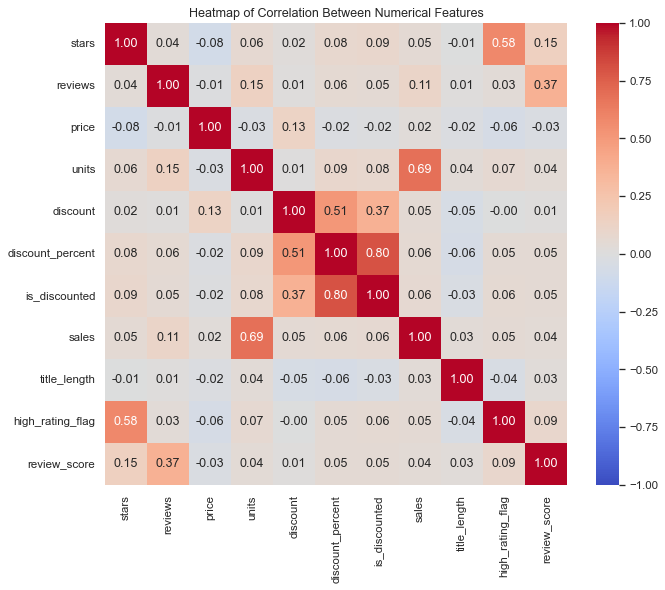

In [35]:
# Select numerical features
numerical_features = df.select_dtypes(include=['int32', 'int64', 'float64'])
# Compute the correlation matrix
corr_matrix = numerical_features.corr()

# Generate a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, vmin=-1)
plt.title('Heatmap of Correlation Between Numerical Features')
plt.show()

- sales and units have a moderately positive correlation, which makes sense as Amazon sells on volume and thus sales increase with higher volume

**is_best_seller vs is_discounted (% of best sellers that were discounted)**

In [36]:
# Calculate the sum of each group for the specified columns
grouped_sum = df.groupby('is_best_seller')[['is_discounted']].sum()

# Calculate the sum of the entire DataFrame for the specified columns
total_sum = df[['is_discounted']].sum()

# Divide the grouped sum by the total sum and multiply by 100 to get the percentage
grouped_percentage = (grouped_sum / total_sum) * 100

# Display the resulting DataFrame with percentages
grouped_percentage.T

is_best_seller,False,True
is_discounted,98.84,1.16


- 1.16% of best sellers were discounted

In [37]:
# Calculate the sum of each group for the specified columns
grouped_sum = df.groupby('is_discounted')[['units', 'stars', 'reviews', 'sales', 'high_rating_flag']].sum()

# Calculate the sum of the entire DataFrame for the specified columns
total_sum = df[['units', 'stars', 'reviews', 'sales', 'high_rating_flag']].sum()

# Divide the grouped sum by the total sum and multiply by 100 to get the percentage
grouped_percentage = ((grouped_sum / total_sum) * 100).round()

# Display the resulting DataFrame with percentages
grouped_percentage.T

is_discounted,0,1
units,55.00,45.00
stars,74.00,26.00
reviews,55.00,45.00
sales,56.00,44.00
high_rating_flag,74.00,26.00


In [38]:
df.head()

,title,img_url,product_url,stars,reviews,price,is_best_seller,units,category_name,discount,discount_percent,is_discounted,sales,title_length,high_rating_flag,price_range,review_score
0,"Sion Softside Expandable Roller Luggage, Black...",https://m.media-amazon.com/images/I/815dLQKYIY...,https://www.amazon.com/dp/B014TMV5YE,4.50,0,139.99,False,2000,Suitcases,0.00,0.00,0,279980.00,69,1,High,0.00
1,Luggage Sets Expandable PC+ABS Durable Suitcas...,https://m.media-amazon.com/images/I/81bQlm7vf6...,https://www.amazon.com/dp/B07GDLCQXV,4.50,0,169.99,False,1000,Suitcases,40.00,19.05,1,169990.00,75,1,High,0.00
2,Platinum Elite Softside Expandable Checked Lug...,https://m.media-amazon.com/images/I/71EA35zvJB...,https://www.amazon.com/dp/B07XSCCZYG,4.60,0,365.49,False,300,Suitcases,64.50,15.00,1,109647.00,141,1,High,0.00
3,Freeform Hardside Expandable with Double Spinn...,https://m.media-amazon.com/images/I/91k6NYLQyI...,https://www.amazon.com/dp/B08MVFKGJM,4.60,0,291.59,False,400,Suitcases,62.78,17.72,1,116636.00,82,1,High,0.00
4,Winfield 2 Hardside Expandable Luggage with Sp...,https://m.media-amazon.com/images/I/61NJoaZcP9...,https://www.amazon.com/dp/B01DJLKZBA,4.50,0,174.99,False,400,Suitcases,135.00,43.55,1,69996.00,92,1,High,0.00


### Creating a threshold for units for binary classification

In [39]:
# Threshold at the 75th percentile (which means 25% of the products)
df['target'] = (df['units'] >= 100).astype(int)

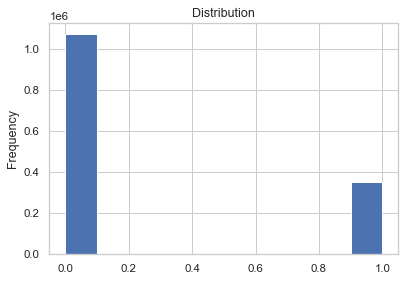

In [40]:
# Plotting histogram of target to see distribution
df['target'].plot(kind='hist', title='Distribution')
plt.show()

**What percent of sales (revenue) do those products contribute to the total sales?**

In [41]:
# what percent of sales (revenue) do thost products contribute to the total sales?
df.loc[df.target == 1]['sales'].sum() / df.sales.sum()

0.9512532515287693

- 95% of sales come from 25% of the products which sell 100+ units (Pareto-like)!

### Before finalizing the dataset, let's remove redundant variables or those that will cause data leakage

In [42]:
df1 = df.copy()

In [43]:
df1.drop(columns=['units', 'is_discounted', 'price_range', 'discount', 'title_length', 'high_rating_flag', 'review_score', 'sales'], axis=1, inplace=True)

### Save final dataframe as csv for subsequent notebook

In [44]:
# Save the final DataFrame after feature engineering
final_df = df1  

# Specify the file name
output_file_name = '../data/feature_engineering.csv' 

# Save to CSV
final_df.to_csv(output_file_name, index=False)

# Print a confirmation message
print(f"DataFrame saved as '{output_file_name}'.")

DataFrame saved as '../data/feature_engineering.csv'.
